In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import decimal
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm
from sklearn.svm import SVR

#data = pd.read_csv('data', parse_dates=[[0,1]], infer_datetime_format=True)
df = pd.read_csv("training.csv", infer_datetime_format=True,low_memory=False)

columnNames = ['int_rate','id_loan','id_borrower','loan_amt','funded_amt','funded_amt_inv',
              'term','grade','subgrade','emp_title','emp_length','home_ownership','annual_inc',
               'verification_status','issue_d','purpose','loan_cat','loan_title','zip_code',
               'state','dti','delinq_2yrs','earliest_cr_line','inq_last_6mths','mths_since_last_deliq',
               'mths_since_last_record','num_opencr_line','num_der_rec','revol_bal','revol_util',
               'total_cr_line','init_list_status']

df.columns = columnNames

# Pandas can not store NaN in int type column, thus had remove all NaNs from them as well
for col in ('loan_amt','funded_amt','funded_amt_inv', 'term'):
    df = df[pd.notnull(df[col])]
    
# reset index
df = df.reset_index(drop=True)

D = decimal.Decimal
# Pandas can not store NaN in int type column, thus had remove all NaNs
for col in ('loan_amt','funded_amt','funded_amt_inv','term'):
    df[col] = df[col].str.replace(r'[^-+\d.]', '').astype(D)
    df[col] = df[col].astype('int')
    
#  Convert columns having % from obj(string type) to float and divide by 100    
df['int_rate'] = df['int_rate'].str.replace('%','').astype('float')/100

# Remove the rows where int_rate is missing
df = df[pd.notnull(df['int_rate'])]
# Reset index, this is critical
df = df.reset_index(drop=True)

df.drop(['id_loan','id_borrower'],1, inplace=True)

from datetime import datetime
# Read the column in the correct format
temp = pd.to_datetime(df['issue_d'],format = '%b-%d')

date_format = "%m/%d/%Y"
dttoday = datetime.strptime('1/1/1900', date_format)

d = np.zeros(len(temp))
for i in range(len(temp)):
    try:
        d[i] = ((np.timedelta64(temp[i] - pd.Timestamp(dttoday),'D').astype(int))/365)
        #break
    except:
        d[i] = ((np.timedelta64(temp[i] - pd.Timestamp(dttoday),'M').astype(int))/12)

df['issue_d'] = d

# Remove the rows where annual income claim is larger than 1 million
df = df[df['annual_inc'] <= 1000000]
# Reset index, this is critical
df = df.reset_index(drop=True)

df.drop(['emp_title'],1, inplace=True)

df.replace('n/a', np.nan,inplace=True)
df.emp_length.fillna(value=0,inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['emp_length'] = df['emp_length'].astype(int)

df.drop(['purpose'],1, inplace=True)
df.drop(['loan_title'],1, inplace=True)
df.drop(['zip_code'],1, inplace=True)

from datetime import datetime
# Read the column in the correct format
t = pd.to_datetime(df['earliest_cr_line'],format = '%b-%y')

date_format = "%m/%d/%Y"
dttoday = datetime.strptime('1/1/2017', date_format)

d = np.zeros(len(t))
for i in range(len(t)):
    try:
        d[i] = ((np.timedelta64(t[i] - pd.Timestamp(dttoday),'D').astype(int))/-365)
        #break
    except:
        d[i] = ((np.timedelta64(t[i] - pd.Timestamp(dttoday),'M').astype(int))/-12)

d[d<0] = d[d<0] + 100

df['earliest_cr_line'] = d

df.revol_util = pd.Series(df.revol_util).str.replace('%', '').astype(float)

df.drop(['funded_amt','funded_amt_inv','mths_since_last_record', 'total_cr_line','subgrade'], axis=1, inplace=True)

cor = df.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]

df.drop(['mths_since_last_deliq'], axis=1, inplace=True)

In [2]:
import time
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, make_scorer
from matplotlib import pyplot as plt
from sklearn.grid_search import GridSearchCV

param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9, 17],
              'max_features': [1.0, 0.3, 0.1]
              }
# param_grid = {'learning_rate': [0.1],
#               'max_depth': [4],
#               'min_samples_leaf': [3],
#               'max_features': [1.0],
#               }

#http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV
#http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
#training file is huge so using non-repeated 5 cv is sufficient
est = GridSearchCV(ensemble.GradientBoostingRegressor(n_estimators=100),
                   param_grid, n_jobs=4, refit=True, cv = 5,scoring='mean_squared_error')

# Create an acceptable formula for our machine learning algorithms
formula_ml = 'int_rate ~ loan_amt '
for i in range(2,len(df.columns)):
    
    if str(df.dtypes[i]) == 'object': 
        formula_ml = formula_ml + ' + ' + 'C(' + df.columns[i] + ')'
    elif (str(df.dtypes[i]) == 'float64') | (str(df.dtypes[i]) == 'float32'):
        formula_ml = formula_ml + ' + ' + df.columns[i]
        
# import the machine learning library that holds the randomforest
import sklearn.ensemble as ske

# Create the random forest model and fit the model to our training data
y1, x1 = dmatrices(formula_ml, data=df, return_type='dataframe')
y1 = np.asarray(y1).ravel()

# For prototype build, only use a tiny portion to test to save time
testet = int(x1.shape[0] * 0.05)
x1,y1 =  x1[:testet], y1[:testet]

## Split data for testing and training
offset = int(x1.shape[0] * 0.75)
X_train1, y_train1 = x1[:offset], y1[:offset]
X_test1, y_test1 = x1[offset:], y1[offset:]


start = time.clock()

#instantiate and fit our model
est.fit(X_train1, y_train1)

best_params = est.best_params_



# Tuning parameter phase, using 
#http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html
print("Best parameters set found on development set:")
print()
print(est.best_params_)
print()
print("It has the best score of %f" %est.best_score_ )
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in est.grid_scores_:
    print("%0.6f (+/-%0.06f) for %r"
            % (mean_score, scores.std() * 2, params))
    print()    
## TO-DO: draw plots to visualize the scores e.g. http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html


Best parameters set found on development set:

{'min_samples_leaf': 5, 'max_features': 1.0, 'learning_rate': 0.1, 'max_depth': 6}

It has the best score of -0.000120

Grid scores on development set:

-0.000122 (+/-0.000130) for {'min_samples_leaf': 3, 'max_depth': 4, 'learning_rate': 0.1, 'max_features': 1.0}

-0.000122 (+/-0.000128) for {'min_samples_leaf': 5, 'max_depth': 4, 'learning_rate': 0.1, 'max_features': 1.0}

-0.000124 (+/-0.000129) for {'min_samples_leaf': 9, 'max_features': 1.0, 'learning_rate': 0.1, 'max_depth': 4}

-0.000127 (+/-0.000125) for {'min_samples_leaf': 17, 'max_features': 1.0, 'learning_rate': 0.1, 'max_depth': 4}

-0.000120 (+/-0.000121) for {'min_samples_leaf': 3, 'max_depth': 4, 'learning_rate': 0.1, 'max_features': 0.3}

-0.000124 (+/-0.000120) for {'min_samples_leaf': 5, 'max_depth': 4, 'learning_rate': 0.1, 'max_features': 0.3}

-0.000125 (+/-0.000120) for {'min_samples_leaf': 9, 'max_features': 0.3, 'learning_rate': 0.1, 'max_depth': 4}

-0.000123 (+/-0

RMSE: 0.0119


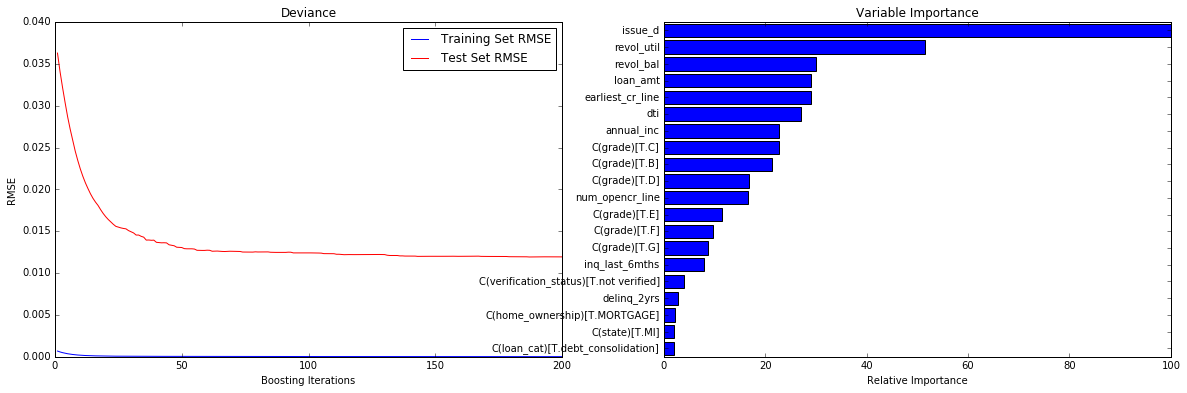

In [3]:
## Evaluate model using tuned parameter
#: http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html variable importance
# Fit G boosting model using the tuned selected parameter set
clf = ensemble.GradientBoostingRegressor(n_estimators=200,**est.best_params_)

clf.fit(X_train1, y_train1)
rmse = mean_squared_error(y_test1, clf.predict(X_test1))**0.5
print("RMSE: %.4f" % rmse)

params['n_estimators'] = 200

###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test1)):
    test_score[i] = mean_squared_error(y_test1, y_pred)**0.5
    #test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set RMSE')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set RMSE')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('RMSE')

###############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-20:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(x1.columns)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [4]:
# from sklearn import cross_validation
# bs1 = cross_validation.ShuffleSplit(len(x1), n_iter=3, test_size=.25, random_state=0)
# # Bootstrap Cross validation
# # http://cbio.ensmp.fr/~nvaroquaux/scikit-learn/modules/generated/sklearn.cross_validation.Bootstrap.html
# g_rmse = []
# for train_index, test_index in bs1:
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print()
#     clf.fit(x1[train_index], y1[train_index])
#     rmse = mean_squared_error(y1[test_index], clf.predict(x1[test_index]))**0.5
#     g_rmse.append(rmse)
#     print("MSE of using Lasso regulated OLS is: %.6f" % rmse)

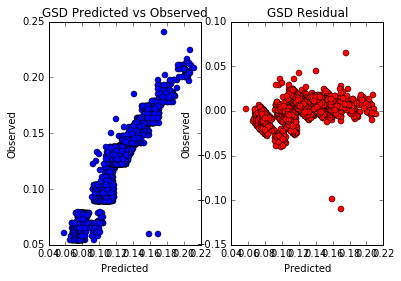

In [47]:
plt.subplot(121) 
plt.plot(clf.predict(X_test1),y_test1,'bo')
plt.title("GSD Predicted vs Observed")
plt.xlabel('Predicted')
plt.ylabel('Observed')

plt.subplot(122) 
plt.plot(clf.predict(X_test1),y_test1 - clf.predict(X_test1),'ro')
plt.title("GSD Residual")
plt.xlabel('Predicted')
plt.ylabel('Observed')

In [8]:
yyy = y_test1 - clf.predict(X_test1)
#yyy[abs(yyy) == abs(yyy).max()]
np.argmin(yyy)
df[df['int_rate'] == y_test1[760]]

,int_rate,loan_amt,term,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_cat,...,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_deliq,num_opencr_line,num_der_rec,revol_bal,revol_util,init_list_status
40171,0.1311,20375,60,B,9,MORTGAGE,68000.00,VERIFIED - income source,0.443836,debt_consolidation,...,10.32,0,12.926027,1,NaN,6,0,6605,41.0,f
81804,0.1311,16000,36,NaN,5,OWN,62000.00,not verified,0.194521,debt_consolidation,...,10.51,0,17.684932,1,NaN,10,0,3163,12.4,f
88199,0.1311,9800,36,B,10,OWN,50000.00,not verified,0.279452,debt_consolidation,...,13.34,2,25.438356,0,12,14,0,9806,39.7,f
91573,0.1311,8000,36,B,8,MORTGAGE,31000.00,not verified,0.361644,house,...,14.41,0,24.769863,3,80,9,0,3508,25.6,f
78551,0.1311,7925,36,B,8,NaN,35000.00,VERIFIED - income,0.117808,debt_consolidation,...,24.07,0,15.178082,0,NaN,6,0,5489,53.8,f
100091,0.1311,6000,36,NaN,10,RENT,35000.00,not verified,0.446575,credit_card,...,14.47,0,18.098630,2,80,8,0,5148,29.6,f
75166,0.1311,9000,36,B,10,MORTGAGE,60000.00,VERIFIED - income,0.117808,credit_card,...,31.92,0,19.180822,1,NaN,17,0,16937,61.4,f
48275,0.1311,12000,36,NaN,10,RENT,40000.00,VERIFIED - income source,0.610959,debt_consolidation,...,12.48,0,25.523288,0,77,9,0,12767,38.2,f
97022,0.1311,12000,36,B,0,RENT,57576.00,VERIFIED - income,0.361644,debt_consolidation,...,18.45,0,18.013699,0,NaN,12,0,15449,63.3,f
6665,0.1311,3500,36,NaN,2,RENT,39000.00,not verified,0.271233,debt_consolidation,...,19.38,0,14.010959,1,35,6,0,2426,27.0,f


In [24]:
################################
## Categorical predictors one hot encoding ###
################################
df2 = df.copy()

## Create dummy variables for linear regression
df2 = pd.get_dummies(df2)

## Drop NaN values, another option is to impute
df2 = df2.dropna()
# reset index
df2 = df2.reset_index(drop=True)

In [25]:
cor = df2.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]

mths_since_last_deliq        delinq_2yrs               -0.576065
home_ownership_RENT          home_ownership_MORTGAGE   -0.626283
loan_cat_debt_consolidation  loan_cat_credit_card      -0.612436
init_list_status_w           init_list_status_f        -1.000000
dtype: float64

In [26]:
df2.drop(['home_ownership_RENT', 'verification_status_VERIFIED - income source',
         'loan_cat_debt_consolidation','init_list_status_w'], axis=1, inplace=True)

In [27]:
# Create response vector y and flattern it
y = df2.int_rate.values
y = np.asarray(y).ravel()

# Create a copy of df
df2.drop('int_rate',axis = 1, inplace=True)

# Randomly shuffle 
x, y = shuffle(df2.values, y, random_state=30)

## Centering and scaling data
from sklearn import preprocessing
x = preprocessing.scale(x)
#y = preprocessing.scale(y)

In [28]:
# For prototype build, only use a tiny portion to test to save time
# testet = int(x.shape[0] * 0.05)
# x,y =  x[:testet], y[:testet]

## Split data for testing and training
offset = int(x.shape[0] * 0.75)
X_train, y_train = x[:offset], y[:offset]
X_test, y_test = x[offset:], y[offset:]

In [29]:
################################
        ## Lasso OLS ###
################################
from sklearn import linear_model

# Alpha parameters to be tuned
param_grid = {'alpha': [0.1,0.01,0.001,0.0001, 0.00001],
              }
# http://scikit-learn.org/stable/modules/linear_model.html # using lasso
# Grid searching lasso regulated regression, using mean_squared_error as the scoring method
est = GridSearchCV(linear_model.Lasso(),
                   param_grid, n_jobs=4, refit=True, cv = 5,scoring='mean_squared_error')
est.fit(X_train, y_train)

# Tuning parameter phase, using 
#http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html
print("Best parameters set found on development set:")
print()
print(est.best_params_)
print()
print("It has the best score of %f" %est.best_score_ )
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in est.grid_scores_:
    print("%0.6f (+/-%0.06f) for %r"
            % (mean_score, scores.std() * 2, params))
    print()    
 
# Build lasso model using the best params set
lasso = linear_model.Lasso(**est.best_params_)

lasso.fit(X_train, y_train)
rmse = mean_squared_error(y_test, lasso.predict(X_test))**0.5
print("RMSE of using Lasso regulated OLS is: %.6f" % rmse)

Best parameters set found on development set:

{'alpha': 1e-05}

It has the best score of -0.001064

Grid scores on development set:

-0.002066 (+/-0.000021) for {'alpha': 0.1}

-0.001589 (+/-0.000018) for {'alpha': 0.01}

-0.001089 (+/-0.000009) for {'alpha': 0.001}

-0.001064 (+/-0.000007) for {'alpha': 0.0001}

-0.001064 (+/-0.000007) for {'alpha': 1e-05}

RMSE of using Lasso regulated OLS is: 0.032642


Best parameters set found on development set:

{'alpha': 1}

It has the best score of -0.001064

Grid scores on development set:

-0.001064 (+/-0.000007) for {'alpha': 1}

-0.001064 (+/-0.000007) for {'alpha': 0.5}

-0.001064 (+/-0.000007) for {'alpha': 0.2}

-0.001064 (+/-0.000007) for {'alpha': 0.1}

-0.001064 (+/-0.000007) for {'alpha': 0.05}

-0.001064 (+/-0.000007) for {'alpha': 0.02}

-0.001064 (+/-0.000007) for {'alpha': 0.01}

RMSE of using Ridge regulated OLS is: 0.032644


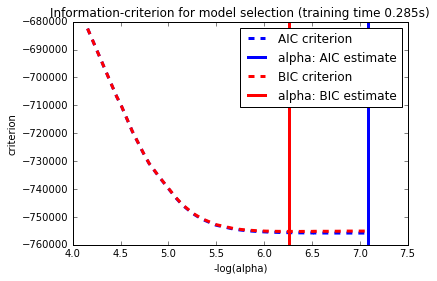

In [30]:
################################
        ## Ridge OLS ###
################################
param_grid = {'alpha': [1,0.5,0.2,0.1, 0.05, 0.02, 0.01],
              }
# http://scikit-learn.org/stable/modules/linear_model.html using Ridge
est = GridSearchCV(linear_model.Ridge(),
                   param_grid, n_jobs=4, refit=True, cv = 5,scoring='mean_squared_error')
est.fit(X_train, y_train)

# Tuning parameter phase, using 
#http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html
print("Best parameters set found on development set:")
print()
print(est.best_params_)
print()
print("It has the best score of %f" %est.best_score_ )
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in est.grid_scores_:
    print("%0.6f (+/-%0.06f) for %r"
            % (mean_score, scores.std() * 2, params))
    print()   
    
    
# Build lasso model using the best params set
ridge = linear_model.Ridge(**est.best_params_)

ridge.fit(X_train, y_train)
rmse = mean_squared_error(y_test, ridge.predict(X_test))**0.5
print("RMSE of using Ridge regulated OLS is: %.6f" % rmse)
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn import datasets

# http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html
##############################################################################
# LassoLarsIC: least angle regression with BIC/AIC criterion
#http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html

model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X_train, y_train)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_train, y_train)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)

plt.show()

Best parameters set found on development set:

{'alpha': 1}

It has the best score of -0.001064

Grid scores on development set:

-0.001064 (+/-0.000007) for {'alpha': 1}

-0.001064 (+/-0.000007) for {'alpha': 0.5}

-0.001064 (+/-0.000007) for {'alpha': 0.2}

-0.001064 (+/-0.000007) for {'alpha': 0.1}

-0.001064 (+/-0.000007) for {'alpha': 0.05}

-0.001064 (+/-0.000007) for {'alpha': 0.02}

-0.001064 (+/-0.000007) for {'alpha': 0.01}

RMSE of using Ridge regulated OLS is: 0.032644


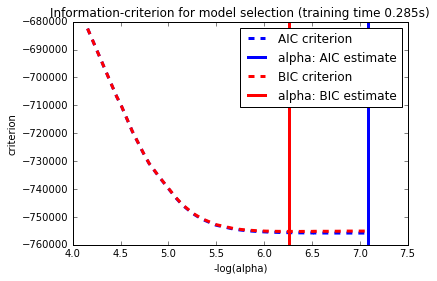

In [30]:
################################
        ## Ridge OLS ###
################################
param_grid = {'alpha': [1,0.5,0.2,0.1, 0.05, 0.02, 0.01],
              }
# http://scikit-learn.org/stable/modules/linear_model.html using Ridge
est = GridSearchCV(linear_model.Ridge(),
                   param_grid, n_jobs=4, refit=True, cv = 5,scoring='mean_squared_error')
est.fit(X_train, y_train)

# Tuning parameter phase, using 
#http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html
print("Best parameters set found on development set:")
print()
print(est.best_params_)
print()
print("It has the best score of %f" %est.best_score_ )
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in est.grid_scores_:
    print("%0.6f (+/-%0.06f) for %r"
            % (mean_score, scores.std() * 2, params))
    print()   
    
    
# Build lasso model using the best params set
ridge = linear_model.Ridge(**est.best_params_)

ridge.fit(X_train, y_train)
rmse = mean_squared_error(y_test, ridge.predict(X_test))**0.5
print("RMSE of using Ridge regulated OLS is: %.6f" % rmse)
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn import datasets

# http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html
##############################################################################
# LassoLarsIC: least angle regression with BIC/AIC criterion
#http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html

model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X_train, y_train)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_train, y_train)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)

plt.show()

In [31]:
################################
## Model select between Ridge and Lasso ###
################################

## Bootstrap sampling index preparation
from sklearn import cross_validation
bs = cross_validation.ShuffleSplit(len(x), n_iter=3, test_size=.25, random_state=0)

# Bootstrap Cross validation
# http://cbio.ensmp.fr/~nvaroquaux/scikit-learn/modules/generated/sklearn.cross_validation.Bootstrap.html
r_rmse = []
l_rmse = []
for train_index, test_index in bs:
    print("TRAIN:", train_index, "TEST:", test_index)
    print()
    ridge.fit(x[train_index], y[train_index])
    rmse = mean_squared_error(y[test_index], ridge.predict(x[test_index]))**0.5
    r_rmse.append(rmse)
    print("RMSE of using Ridge regulated OLS is: %.6f" % rmse)
    print()
    lasso.fit(x[train_index], y[train_index])
    rmse = mean_squared_error(y[test_index], lasso.predict(x[test_index]))**0.5
    l_rmse.append(rmse)
    print("RMSE of using Lasso regulated OLS is: %.6f" % rmse)

## t test statistical difference of performance
from scipy.stats import ttest_ind

# Use scipy.stats.ttest_ind.
t, p = ttest_ind (l_rmse, r_rmse, equal_var=False)
print ("ttest_ind: t = %g  p = %g" % (t, p))

alpha = 0.5
if (t >0) & (p/2 < alpha): 
    print("We reject the null hypothesis and believe Lasso's rmse is greater than Ridge's mse since when p/2 < alpha and t > 0")
elif (t <0) & (p/2 < alpha): 
    print("We reject the null hypothesis and believe Lasso's rmse is not greater than Ridge's mse since when p/2 < alpha and t < 0")
# else:
#     print("Not reject null hypothesis and believe Lasso's mse is  Ridge's mse since when p/2 < alpha and t > 0")
# AIC
import math
print("the ACI of Lasso is:", math.log(np.mean(l_rmse)**2)*len(y[test_index]) + 2*len(df.columns))
print("the ACI of Ridge is:",math.log(np.mean(r_rmse)**2)*len(y[test_index]) + 2*len(df.columns))

TRAIN: [101762 122757 105574 ...,  95939 117952  43567] TEST: [ 42801 118602 143234 ...,  84918 108600  10982]

RMSE of using Ridge regulated OLS is: 0.032454

RMSE of using Lasso regulated OLS is: 0.032455
TRAIN: [ 34658 139978 129612 ...,  55694  24459 101056] TEST: [  7276  52257 105960 ...,  53006 114261  88744]

RMSE of using Ridge regulated OLS is: 0.032642

RMSE of using Lasso regulated OLS is: 0.032642
TRAIN: [ 22525 130379  66713 ..., 115788 103974  40845] TEST: [130149 118765 119856 ...,  34099  84372 136941]

RMSE of using Ridge regulated OLS is: 0.032584

RMSE of using Lasso regulated OLS is: 0.032584
ttest_ind: t = -0.00391814  p = 0.997061
We reject the null hypothesis and believe Lasso's rmse is not greater than Ridge's mse since when p/2 < alpha and t < 0
the ACI of Lasso is: -252013.85176017313
the ACI of Ridge is: -252013.15741961822


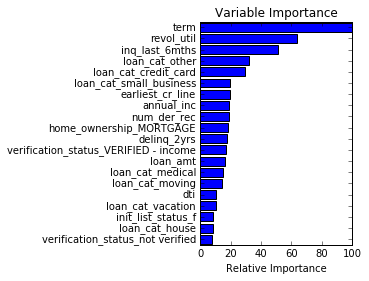

In [32]:
###############################################################################
# Plot feature importance for Lasso OLS

coeff = list(lasso.coef_)
indices = [i for i, x in enumerate(coeff) if x != 0]

coe_importance = lasso.coef_
coe_importance = abs(coe_importance)
#coe_importance = sorted(coe_importance,reverse=True)
# make importances relative to max importance

coe_importance = 100.0 * (coe_importance / coe_importance.max())
sorted_idx = np.argsort(abs(coe_importance))[-20:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, coe_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(df2.columns)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [33]:
## Models Comparison
## evaluate residuals, qq-plot
## learning rate, speed, rmse

In [34]:
#TO-DO compare two models http://scikit-learn.org/stable/auto_examples/plot_kernel_ridge_regression.html
#      include training and predicting time

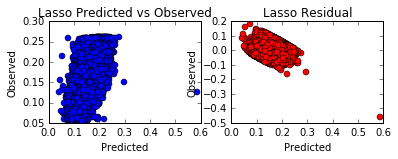

In [35]:
#lasso.fit(X_train, y_train)
plt.subplot(221) 
plt.plot(lasso.predict(X_test),y_test,'bo')
plt.title("Lasso Predicted vs Observed")
plt.xlabel('Predicted')
plt.ylabel('Observed')


plt.subplot(222) 
plt.plot(lasso.predict(X_test),y_test - lasso.predict(X_test),'ro')
plt.title("Lasso Residual")
plt.xlabel('Predicted')
plt.ylabel('Observed')


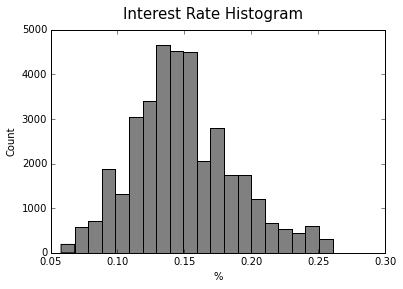

In [183]:
plt.hist(df['int_rate'],bins=20,color = 'grey')
plt.suptitle('Interest Rate Histogram ', fontsize=15)
plt.xlabel('%')
plt.ylabel('Count')
plt.show()

In [51]:
# Read the training.csv into data frame df
td = pd.read_csv("testing.csv", infer_datetime_format=True,low_memory=False)

# Name the data frame with the columnNames
td.columns = columnNames

In [52]:
td

,int_rate,id_loan,id_borrower,loan_amt,funded_amt,funded_amt_inv,term,grade,subgrade,emp_title,...,earliest_cr_line,inq_last_6mths,mths_since_last_deliq,mths_since_last_record,num_opencr_line,num_der_rec,revol_bal,revol_util,total_cr_line,init_list_status
0,NaN,44409194,47416907,"$6,000","$6,000","$6,000",36 months,C,C5,Electrician,...,11/2/2016,1,26,NaN,18,0,19861,64.50%,33,f
1,NaN,44017917,47034722,"$24,000","$24,000","$24,000",36 months,A,A1,Executive Assistant,...,12/1/1968,1,NaN,NaN,12,0,17001,26.20%,36,w
2,NaN,44259158,47306871,"$35,000","$35,000","$35,000",36 months,C,C2,District Sales Leader,...,10/1/1998,0,NaN,NaN,16,0,25797,49.90%,33,w
3,NaN,44429213,47476932,"$10,000","$10,000","$10,000",60 months,D,D1,pharmacy associate,...,2/1/1999,1,NaN,114,13,1,9586,43.80%,21,w
4,NaN,44299188,47346901,"$24,000","$24,000","$24,000",60 months,B,B1,Medical case manager,...,12/2/2016,0,48,NaN,27,0,31842,41.30%,43,w
5,NaN,44057008,47073801,"$18,000","$18,000","$18,000",60 months,B,B3,Solutions Development Senior Analyst,...,8/1/1998,0,NaN,NaN,8,0,18652,64.80%,21,w
6,NaN,41399898,44316683,"$8,000","$8,000","$8,000",36 months,C,C3,Department Manager,...,6/6/2016,0,NaN,NaN,7,0,13775,63.20%,10,w
7,NaN,43801789,46818598,"$24,000","$24,000","$24,000",36 months,B,B2,Senior pastor,...,8/1/2016,1,31,NaN,10,0,20417,68.70%,19,w
8,NaN,44409120,47416833,"$18,000","$18,000","$18,000",60 months,C,C4,Regulatory Compliance,...,1/2/2016,0,72,NaN,9,0,3948,66.90%,23,w
9,NaN,44319155,47376870,"$25,000","$25,000","$25,000",36 months,A,A2,Strategist,...,12/1/2000,0,21,NaN,12,0,12689,41.30%,25,w


In [35]:
    ## Data pre-processing function for GSD
    # Pandas can not store NaN in int type column, thus had remove all NaNs from them as well

def dataPreprocessGSD(df):
    
#         for col in ('loan_amt','funded_amt','funded_amt_inv', 'term'):
        
#             df = df[pd.notnull(df[col])]

        
#         # reset index
#         df = df.reset_index(drop=True)

        D = decimal.Decimal
        # Pandas can not store NaN in int type column, thus had remove all NaNs
        for col in ('loan_amt','funded_amt','funded_amt_inv','term'):
            df[col] = df[col].str.replace(r'[^-+\d.]', '').astype(D)
            df[col] = df[col].astype('int')

        #  Convert columns having % from obj(string type) to float and divide by 100    
        # df['int_rate'] = df['int_rate'].str.replace('%','').astype('float')/100

        # Remove the rows where int_rate is missing
        #df = df[pd.notnull(df['int_rate'])]
        # Reset index, this is critical
        #df = df.reset_index(drop=True)

#         df.drop(['id_loan','id_borrower'],1, inplace=True)

        from datetime import datetime
        # Read the column in the correct format
        temp = pd.to_datetime(df['issue_d'],format = "%m/%d/%Y")

        date_format = "%m/%d/%Y"
        dttoday = datetime.strptime('1/1/1900', date_format)

        d = np.zeros(len(temp))
        for i in range(len(temp)):
            try:
                d[i] = ((np.timedelta64(temp[i] - pd.Timestamp(dttoday),'D').astype(int))/365)
                #break
            except:
                d[i] = ((np.timedelta64(temp[i] - pd.Timestamp(dttoday),'M').astype(int))/12)

        df['issue_d'] = d

        # Remove the rows where annual income claim is larger than 1 million
#         df = df[df['annual_inc'] <= 1000000]
#         # Reset index, this is critical
#         df = df.reset_index(drop=True)

#         df.drop(['emp_title'],1, inplace=True)

        df.replace('n/a', np.nan,inplace=True)
        df.emp_length.fillna(value=0,inplace=True)
        df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
        df['emp_length'] = df['emp_length'].astype(int)

#         df.drop(['purpose'],1, inplace=True)
#         df.drop(['loan_title'],1, inplace=True)
#         df.drop(['zip_code'],1, inplace=True)

        from datetime import datetime
        # Read the column in the correct format
        t = pd.to_datetime(df['earliest_cr_line'],format = "%m/%d/%Y")

        date_format = "%m/%d/%Y"
        dttoday = datetime.strptime('1/1/2017', date_format)

        d = np.zeros(len(t))
        for i in range(len(t)):
            try:
                d[i] = ((np.timedelta64(t[i] - pd.Timestamp(dttoday),'D').astype(int))/-365)
                #break
            except:
                d[i] = ((np.timedelta64(t[i] - pd.Timestamp(dttoday),'M').astype(int))/-12)

        d[d<0] = d[d<0] + 100

        df['earliest_cr_line'] = d

        df.revol_util = pd.Series(df.revol_util).str.replace('%', '').astype(float)

#         df.drop(['funded_amt','funded_amt_inv','mths_since_last_record', 'total_cr_line','subgrade'], axis=1, inplace=True)

#         cor = df.corr()
#         cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
#         cor = cor.stack()
#         cor[(cor > 0.55) | (cor < -0.55)]

#         df.drop(['mths_since_last_deliq'], axis=1, inplace=True)

        return df

In [53]:
td = dataPreprocessGSD(td)

In [55]:
df

,int_rate,loan_amt,term,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_cat,state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,num_opencr_line,num_der_rec,revol_bal,revol_util,init_list_status
0,0.1189,25000,36,B,1,RENT,85000,VERIFIED - income,0.602740,debt_consolidation,CA,19.48,0,22.931507,0,10,0,28854,52.1,f
1,0.1071,7000,36,B,1,RENT,65000,not verified,0.347945,credit_card,NY,14.29,0,16.263014,0,7,0,33623,76.7,f
2,0.1699,25000,36,D,1,RENT,70000,VERIFIED - income,0.616438,debt_consolidation,NY,10.50,0,16.597260,0,10,0,19878,66.3,f
3,0.1311,1200,36,C,10,OWN,54000,not verified,0.186301,debt_consolidation,TX,5.47,0,32.021918,0,5,0,2584,40.4,f
4,0.1357,10800,36,C,6,RENT,32000,not verified,0.854795,debt_consolidation,CT,11.63,0,20.098630,1,14,0,3511,25.6,f
5,0.1905,7200,36,D,9,RENT,58000,VERIFIED - income source,0.610959,debt_consolidation,RI,2.05,0,22.769863,0,6,0,3874,90.1,f
6,0.1008,7500,36,B,3,RENT,85000,not verified,0.265753,debt_consolidation,CA,8.10,0,16.178082,1,3,0,33667,73.2,f
7,0.1426,3000,36,C,3,MORTGAGE,80800,not verified,0.687671,credit_card,TX,14.97,1,18.517808,0,13,0,4740,39.5,f
8,0.0788,4000,36,A,1,MORTGAGE,148000,not verified,0.109589,credit_card,TX,16.98,0,23.687671,0,11,0,50807,51.0,f
9,0.1496,5600,36,D,1,RENT,45000,not verified,0.109589,debt_consolidation,MD,4.00,0,15.597260,0,5,1,3839,76.8,f


In [54]:
td

,int_rate,id_loan,id_borrower,loan_amt,funded_amt,funded_amt_inv,term,grade,subgrade,emp_title,...,earliest_cr_line,inq_last_6mths,mths_since_last_deliq,mths_since_last_record,num_opencr_line,num_der_rec,revol_bal,revol_util,total_cr_line,init_list_status
0,NaN,44409194,47416907,6000,6000,6000,36,C,C5,Electrician,...,0.164384,1,26,NaN,18,0,19861,64.5,33,f
1,NaN,44017917,47034722,24000,24000,24000,36,A,A1,Executive Assistant,...,48.117808,1,NaN,NaN,12,0,17001,26.2,36,w
2,NaN,44259158,47306871,35000,35000,35000,36,C,C2,District Sales Leader,...,18.265753,0,NaN,NaN,16,0,25797,49.9,33,w
3,NaN,44429213,47476932,10000,10000,10000,60,D,D1,pharmacy associate,...,17.928767,1,NaN,114,13,1,9586,43.8,21,w
4,NaN,44299188,47346901,24000,24000,24000,60,B,B1,Medical case manager,...,0.082192,0,48,NaN,27,0,31842,41.3,43,w
5,NaN,44057008,47073801,18000,18000,18000,60,B,B3,Solutions Development Senior Analyst,...,18.432877,0,NaN,NaN,8,0,18652,64.8,21,w
6,NaN,41399898,44316683,8000,8000,8000,36,C,C3,Department Manager,...,0.572603,0,NaN,NaN,7,0,13775,63.2,10,w
7,NaN,43801789,46818598,24000,24000,24000,36,B,B2,Senior pastor,...,0.419178,1,31,NaN,10,0,20417,68.7,19,w
8,NaN,44409120,47416833,18000,18000,18000,60,C,C4,Regulatory Compliance,...,1.000000,0,72,NaN,9,0,3948,66.9,23,w
9,NaN,44319155,47376870,25000,25000,25000,36,A,A2,Strategist,...,16.095890,0,21,NaN,12,0,12689,41.3,25,w


In [47]:
td.fillna(0, inplace=True)

In [44]:
# Create an acceptable formula for our machine learning algorithms
def formGSDEq(df):
    
    formula_ml = 'int_rate ~ loan_amt  + C(grade) + C(home_ownership) + annual_inc + C(verification_status) + issue_d + C(loan_cat) + C(state) + dti + earliest_cr_line + revol_util + C(init_list_status)'
#     for i in range(2,len(df.columns)):

#         if str(df.dtypes[i]) == 'object': 
#             formula_ml = formula_ml + ' + ' + 'C(' + df.columns[i] + ')'
#         elif (str(df.dtypes[i]) == 'float64') | (str(df.dtypes[i]) == 'float32'):
#             formula_ml = formula_ml + ' + ' + df.columns[i]

    # Create the random forest model and fit the model to our training data
    y1, x1 = dmatrices(formula_ml, data=df, return_type='dataframe')
    
    return x1

In [48]:
xx = formGSDEq(td)

In [49]:
xx

,Intercept,C(grade)[T.B],C(grade)[T.C],C(grade)[T.D],C(grade)[T.E],C(grade)[T.F],C(grade)[T.G],C(home_ownership)[T.OWN],C(home_ownership)[T.RENT],C(verification_status)[T.VERIFIED - income source],...,C(state)[T.WI],C(state)[T.WV],C(state)[T.WY],C(init_list_status)[T.w],loan_amt,annual_inc,issue_d,dti,earliest_cr_line,revol_util
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,6000,68000,116.279452,28.31,0.164384,64.5
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,24000,110480,116.279452,16.03,48.117808,26.2
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,35000,86000,116.279452,32.49,18.265753,49.9
3,1,0,0,1,0,0,0,0,1,1,...,0,0,0,1,10000,30000,116.279452,32.96,17.928767,43.8
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,24000,82500,116.279452,31.03,0.082192,41.3
5,1,1,0,0,0,0,0,0,0,1,...,0,0,0,1,18000,64709,116.279452,34.33,18.432877,64.8
6,1,0,1,0,0,0,0,0,1,1,...,0,0,0,1,8000,30000,116.279452,14.20,0.572603,63.2
7,1,1,0,0,0,0,0,0,1,1,...,0,0,0,1,24000,72000,116.279452,16.32,0.419178,68.7
8,1,0,1,0,0,0,0,0,0,1,...,0,0,0,1,18000,60000,116.279452,17.72,1.000000,66.9
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,25000,113000,116.279452,10.98,16.095890,41.3


In [60]:
xx.insert(7, 'C(home_ownership)[T.MORTGAGE]', 0)
xx.insert(8, 'C(home_ownership)[T.NONE]', 0)
xx.insert(9, 'C(home_ownership)[T.OTHER]', 0)
xx.insert(16, 'C(loan_cat)[T.educational]', 0)
xx.insert(38, 'C(state)[T.IA]', 0)
xx.insert(39, 'C(state)[T.ID]', 0)
xx.insert(47, 'C(state)[T.ME]', 0)
xx.insert(54, 'C(state)[T.NE]', 0)
xx.insert(81, 'delinq_2yrs', 0)
xx.insert(83, 'inq_last_6mths', 0)
xx.insert(84, 'num_opencr_line', 0)
xx.insert(85, 'num_der_rec', 0)
xx.insert(86, 'revol_bal', 0)

In [83]:
clf.predict(xx)

array([ 0.13372783,  0.06995186,  0.11912241, ...,  0.14268331,
        0.12161382,  0.11101329])

In [84]:
result = clf.predict(xx)

In [85]:
with open('t1.csv') as fin, open('Result from Dingchao Zhang.csv', 'w') as fout:
        index = 0
        for line in iter(fin.readline, ''):
            fout.write(line.replace('\n', ', ' + str(result[index]) + '\n'))
            index += 1

In [86]:
import csv
with open('Result from Dingchao Zhang.csv',newline='') as f:
    r = csv.reader(f)
    data = [line for line in r]
with open('Result from Dingchao Zhang.csv','w',newline='') as f:
    w = csv.writer(f)
    w.writerow(['Lasso OLR Prediction','Gradient Boosting Prediction'])
    w.writerows(data)

In [87]:
import os
os.remove('t1.csv')

In [82]:
for i in range(len(X_train1.columns)):
    if X_train1.columns[i] != xx.columns[i]:
        print(i,X_train1.columns[i],xx.columns[i])